# Исследование объявлений о продаже квартир
___
### Содержание
___
<a id='top'></a>
1. [Постановка задачи](#1)
2. [Общая информация о данных](#2)
3. [Предобработка данных](#3)
 * 3.1 [Проверка на отрицательные значения](#3.1)
 * 3.2 [Изучение пропущенных значений](#3.2)
 * 3.3 [Приведение данных к нужным типам](#3.3)
 * 3.4 [Проверка на дубликаты](#3.4)
4. [Добавление новых столбцов](#4)
5. [Исследовательский анализ данных](#5)
 * 5.1 [Изучение  параметров таблицы](#5.1)
 * 5.2 [Изучим время продажи квартиры](#5.2)
 * 5.3 [Убираем редкие и выбивающиеся значения](#5.3)
 * 5.4 [Изучим как факторы влияют на стоимость квартиры](#5.4)
 * 5.5 [Изучение ТОП-10](#5.5)
 * 5.6 [Изучение центра города](#5.6)
6. [Вывод](#6)

<a id='1'></a>

## 1. Постановка задачи

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<a id='2'></a>

## 2. Общая информация о данных

Откроем файл с данными и изучим общую информацию

In [161]:
import pandas as pd
import matplotlib.pyplot as plt

In [162]:
pd.set_option('display.max_columns', 30)

In [163]:
# прочитаем файлы:

df = pd.read_csv('real_estate_data.csv', sep='\t')

display(df.head())
print()
print(df.info())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest  

Из общей информации видим достаточно объемную таблицу, много колонок. Во многих колонках есть пропуски, в некоторых пропусков очень много (например is_apartment, parks_nearest, ponds_nearest). Попробуем разобраться что это за пропуски и как их можно заполнить. А также проверим тип данных, в некоторых колонках его нужно заменить.

<a id='3'></a>
<a id='3.1'></a>

## 3. Предобработка данных
### 3.1 Проверка на отрицательные значения<div align=right>[To top](#top)</div>

In [164]:
# используем для этого цикл:

for column_name in df.dtypes.index:
    if df[column_name].dtypes=='int64' or df[column_name].dtypes=='float64':# проверка на принадлежность данных к числовым типам
        
        if df[df[column_name] < 0][column_name].count() > 0:
            print('|{: <20}|{: >4}|'.format(column_name, 'Есть'))
        else:
            print('|{: <20}|{: >4}|'.format(column_name, 'Нет'))

|total_images        | Нет|
|last_price          | Нет|
|total_area          | Нет|
|rooms               | Нет|
|ceiling_height      | Нет|
|floors_total        | Нет|
|living_area         | Нет|
|floor               | Нет|
|kitchen_area        | Нет|
|balcony             | Нет|
|airports_nearest    | Нет|
|cityCenters_nearest | Нет|
|parks_around3000    | Нет|
|parks_nearest       | Нет|
|ponds_around3000    | Нет|
|ponds_nearest       | Нет|
|days_exposition     | Нет|


Отлично, отрицательных значений нет.

<a id='3.2'></a>

### 3.2 Изучение пропущенных значений<div align=right>[To top](#top)</div>

Первый в списке с пропущенными значениями столбец с высотой потолков. Проверим есть ли выбросы в массиве и при их наличии заполним пропуски медианным значением. Если выбросов нет, то можно заполнить средним значением.

In [165]:
# проверим высоту потолков менее двух метров:

df[df['ceiling_height'] < 2]['ceiling_height'].count()

3

In [166]:
# проверим высоту потолков более 5 метров:

df[df['ceiling_height'] > 5]['ceiling_height'].count()

36

In [167]:
# заполним пропуски медианным значением:

df.loc[df['ceiling_height'].isnull(), 'ceiling_height'] = df['ceiling_height'].median()

# выполним проверку:

df[df['ceiling_height'].isnull()]['ceiling_height'].count()

0

Далее столбец с общим количеством этажей в домах.<br>Узнать точно количество этажей в доме основываясь на табличных данных невозможно. Применить серднее или медиану тоже не выход, так как количество этажей в доме может оказаться ниже, чем расположение квартиры в столбце floor. Поэтому вижу два выхода: пропуски в floors_total заменить соответствующими значениями из столбца floor или заменить пропуски на максимальное значение столбца floor в выборке пропусков. В первом случае все квартиры в выборке будут находиться на последнем этаже. Во втором - будет разнообразие среди положения квартир в доме. Выбор пал на второй вариант.

In [168]:
# вычислим максимальное значение столбца floor в выборке пропусков:

df[df['floors_total'].isnull()]['floor'].max()

24

In [169]:
# заполним пропуски этим значением:

df['floors_total'] = df['floors_total'].fillna(24)

In [170]:
# проверка:

df[df['floors_total'].isnull()]['floors_total']

Series([], Name: floors_total, dtype: float64)

В столбце с жилой площадью заполним пропуски медианным значением по категориям. В качестве категорий выступит количество комнат столбца 'rooms'. Т.к. далее мы по тойже схеме будем заполнять пропуски в колонке с площадью кухни, то напишем функцию.

Но перед этим проверим колонку 'rooms' на пропуски и нулевые значения, т.к. комнат не может быть меньше одной даже если это студия.

In [171]:
df[df['rooms'].isnull()]['rooms'].count()

0

In [172]:
df[df['rooms']==0]['rooms'].count()

197

In [173]:
# заменим все нули на единицу

df.loc[df['rooms']==0, 'rooms'] = 1

In [174]:
df[df['rooms']==0]['rooms'].count()

0

In [175]:
# определим функцию:

def change_nan_depend_rooms(col):
    number_of_rooms = df['rooms'].unique()
    for number in number_of_rooms:
        df.loc[(df['rooms']==number)&(df[col].isnull()), col] = df[df['rooms']==number][col].median()
    return df

In [176]:
# применим функцию к датафрейму:

df = change_nan_depend_rooms('living_area')

In [177]:
# проверка:

df[df['living_area'].isnull()]['living_area']

Series([], Name: living_area, dtype: float64)

В колонке is_apartment очень много пропусков. Всего 2775 ответов, из них 50 ответили утвердительно. Заполнить эти пропуски не представляется возможным, т.к. нет понятия что подразумевается под апартаментами и нет критериев, по которым можно было бы отнести то или иное жилье к апартаментам (возможно по этой причине люди пропускали эту графу при заполнении своих данных).<br>
Оставим эти пропуски нетронутыми.

In [178]:
df['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Для колонки kitchen_area применим тот же способ заполнения пропусков, что и для living_area.

In [179]:
df[df['kitchen_area'].isnull()]['kitchen_area'].count()

0

In [180]:
# вызовем функцию change_nan_depend_rooms для датафрейма:

df = change_nan_depend_rooms('kitchen_area')

In [181]:
# проверка:

df[df['kitchen_area'].isnull()]['kitchen_area']

Series([], Name: kitchen_area, dtype: float64)

В колонке с количеством балконов пропуски возможно означают, что люди не стали указывать количесвто балконов ввиду их отсутствия. Заполнить их каким либо вменяемым способом не представляется возможным. Поэтому просто заменим все пропуски на ноль.

In [182]:
df['balcony'] = df['balcony'].fillna(0)

Пропуски в остальных столбцах не представляется возможным заполнить каким-либо вменяемым способом на основе исходных данных, поэтому оставим их. Только в столбцах 'parks_around3000', 'ponds_around3000', 'days_exposition' заменим пропуски на ноль, чтобы можно было поменять тип данных на правильный.

In [183]:
column_tochange_type = ['parks_around3000', 'ponds_around3000', 'days_exposition']
for name in column_tochange_type:
    df[name] = df[name].fillna(0)

<a id='3.3'></a>

### 3.3 Приведение данных к нужным типам<div align=right>[To top](#top)</div>

Есть несколько столбцов, в которых необходимо привести данные к нужным типам.

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [185]:
# first_day_exposition нужно привести к типу данных datetime:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# is_apartment нужно привести к типу данных bool:
df['is_apartment'] = df['is_apartment'].astype('bool')

# все нижеперечисленные данные измеряются в целых числах
# floors_total нужно привести к типу данных int:
df['floors_total'] = df['floors_total'].astype('int')

# balcony нужно привести к типу данных int:
df['balcony'] = df['balcony'].astype('int')

# parks_around3000 нужно привести к типу данных int:
df['parks_around3000'] = df['parks_around3000'].astype('int')

# ponds_around3000 нужно привести к типу данных int:
df['ponds_around3000'] = df['ponds_around3000'].astype('int')

#days_exposition нужно привести к типу данных int:
df['days_exposition'] = df['days_exposition'].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

<a id='3.4'></a>

### 3.4 Проверка на дубликаты<div align=right>[To top](#top)</div>

In [186]:
df.duplicated().sum()

0

Данные предобработаны насколько это было возможно. Приступим к следующему шагу.

<a id='4'></a>

## 4. Добавление новых столбцов<div align=right>[To top](#top)</div>

Посчитаем некоторые дополнительные значения, которые добавим в таблицу:

In [187]:
# цена за квадратный метр:
df['price_per_square_meter'] = round(df['last_price'] / df['total_area'], 2)

# отдельно день недели, месяц и год публикации:
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

# этаж квартиры (первый, последний или другой):
def what_floor(row):
    total = row['floors_total']
    specific = row['floor']
    
    if total / specific == total:
        return 'первый'
    elif total / specific == 1:
        return 'последний'
    else:
        return 'другой'
    
df['what_floor'] = df.apply(what_floor, axis=1)

# отношение жилой площади и площади кухни к общей площади жилья:
df['living_area/total_area'] = round(df['living_area'] / df['total_area'], 1)
df['kitchen_area/total_area'] = round(df['kitchen_area'] / df['total_area'], 1)

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,what_floor,living_area/total_area,kitchen_area/total_area
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0,120370.37,3,3,2019,другой,0.5,0.2
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920.79,1,12,2018,первый,0.5,0.3
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.71,3,8,2015,другой,0.6,0.1
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,45.0,9,True,False,False,9.5,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.10,4,7,2015,другой,0.3,0.1
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.00,1,6,2018,другой,0.3,0.4


<a id='5'></a>
<a id='5.1'></a>

## 5. Исследовательский анализ данных

### 5.1 Изучение  параметров таблицы<div align=right>[To top](#top)</div>

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


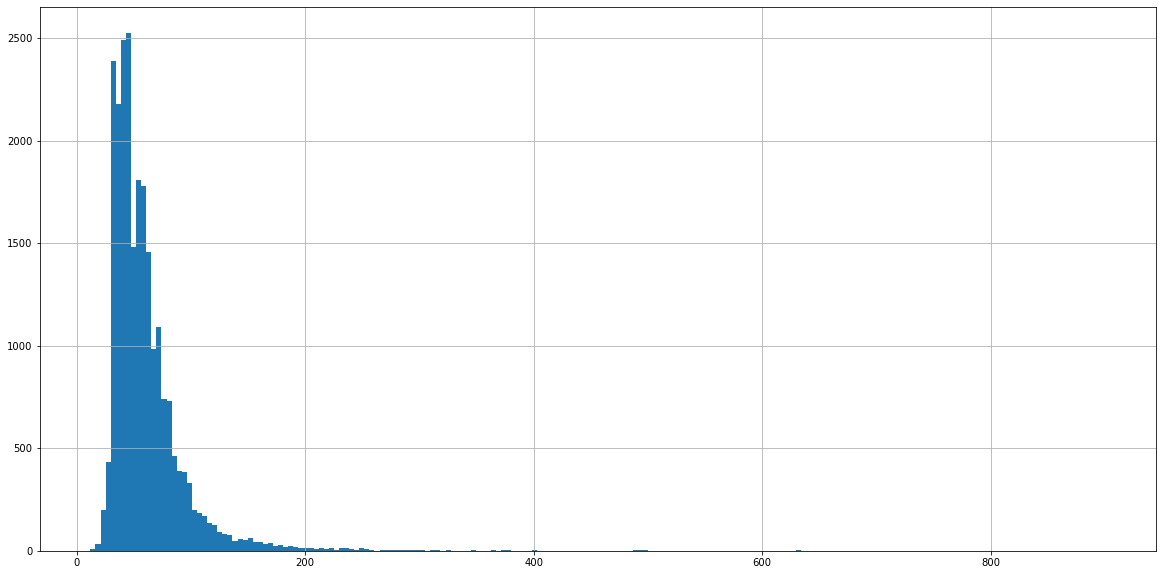

In [188]:
# площадь квартиры:

print(df['total_area'].describe())
df['total_area'].hist(bins=200, figsize=(20, 10))

Наиболее часто встречаются квартиры площадью до 100 квадратных метров, реже до 200. Остальные значения совсем редки. Построим гистограмму в дипазоне 0-200 кв. метров.

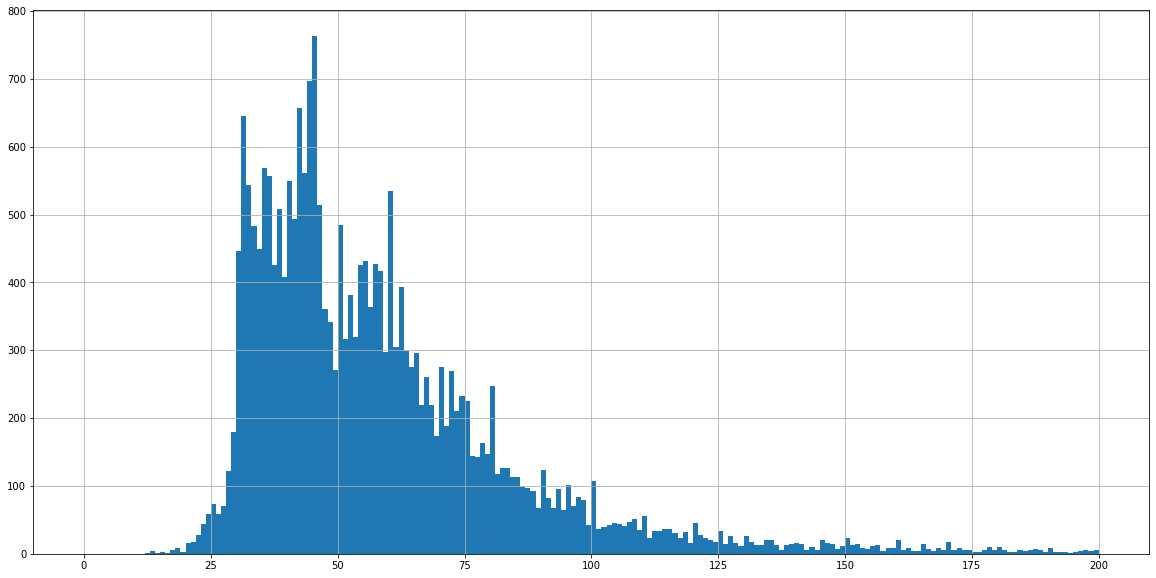

In [189]:
df['total_area'].hist(bins=200, figsize=(20, 10), range=(0, 200))

Гистограмма такого масштаба более детальна и удобна для анализа. Видно, что пик площади квартир приходится на 40 кв. метров.

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


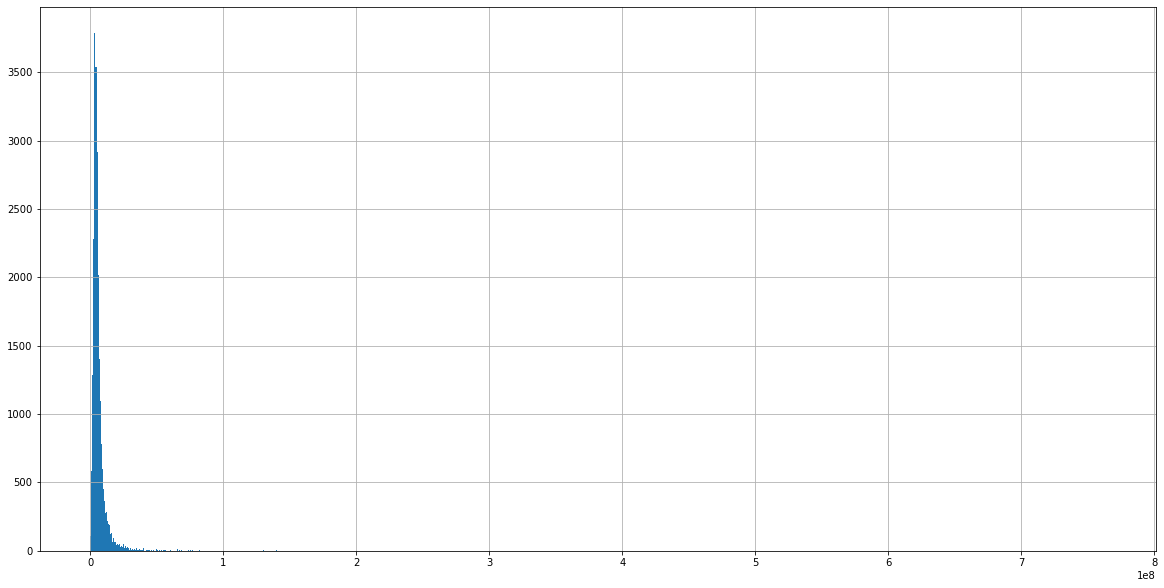

In [190]:
# цена:

print(df['last_price'].describe())
df['last_price'].hist(bins=1000, figsize=(20, 10))

Похожа на Бурдж-Халива. Из-за очень большого выброса в 763 000 000 гитсограма цены за квартиру не очень наглядна. Видим основную частоту в пределах примерно от около нулевого значения до примерно 30 000 000. Построим более детальную гистограмму.

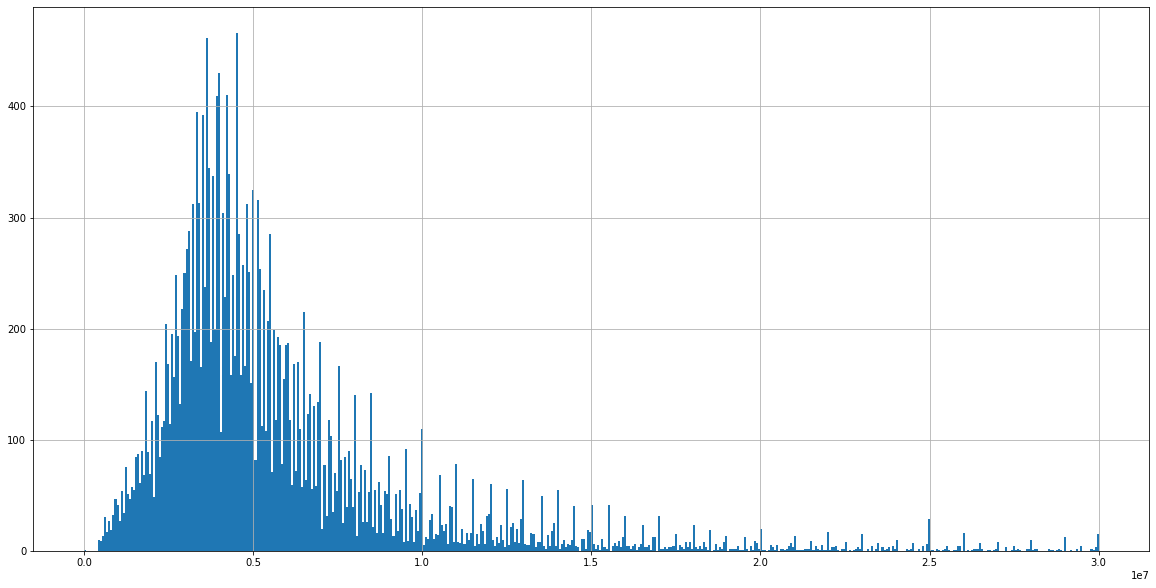

In [191]:
df['last_price'].hist(bins=500, figsize=(20, 10), range=(0, 30000000))

Наибольшее число квартир со стоимостью около 4 млн.

count    23699.000000
mean         2.078948
std          1.066196
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


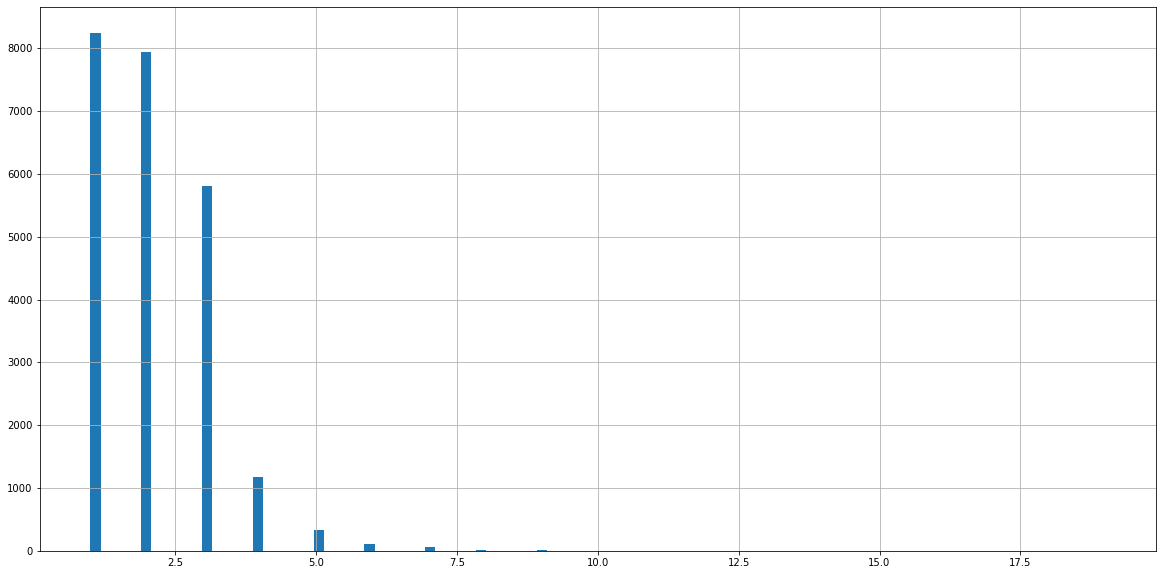

In [192]:
# количество комнат:

print(df['rooms'].describe())
df['rooms'].hist(bins=100, figsize=(20, 10))

На гистограмме видно что большинство кваритр с комнатами от одной до пяти. Есть несколько значений количеством кваритр равным нулю, возможно это опечатки или возможно так люди позиционируют квартиры-студии. Оставим квартиры с комнатами не более семи.

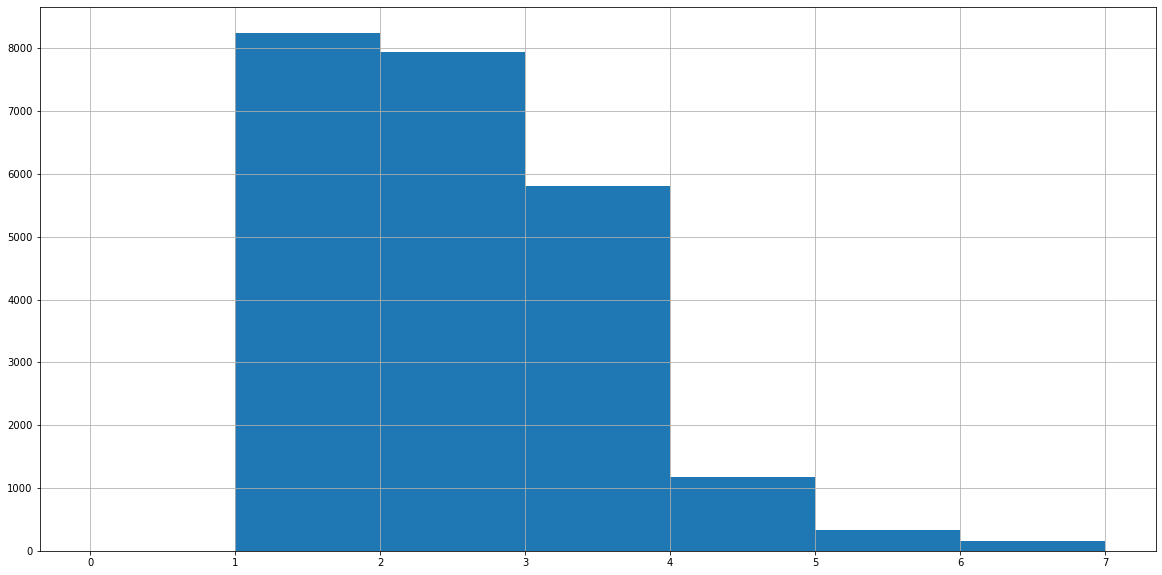

In [193]:
df['rooms'].hist(bins=7, figsize=(20, 10), range=(0, 7))

В основном преобладают двушки и трёшки.

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


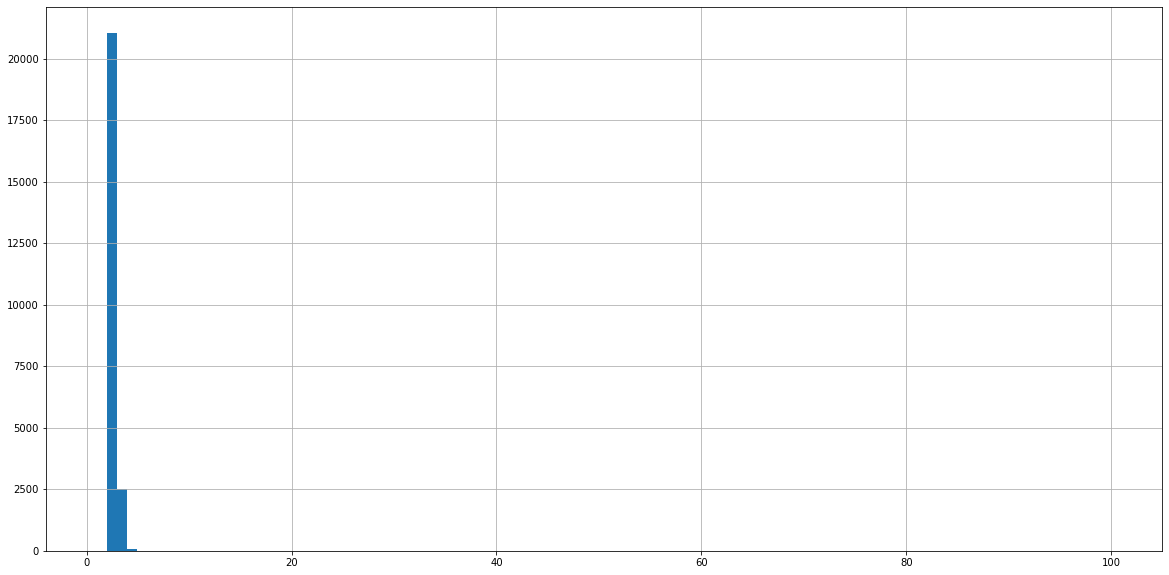

In [194]:
# высота потолков:

print(df['ceiling_height'].describe())
df['ceiling_height'].hist(bins=100, figsize=(20, 10))

С высотой потолков все вполне ожидаемо, основной пик у квартир с вцысотой потолка 2-3 метра. Есть кваритра со стометровым потолком... может это та, что за 763 миллиона? Кто-то продает кёльнский собор? Все может быть... Посмотрим пристальнее, оставим квартиры в диапазоне 2-4 метра.

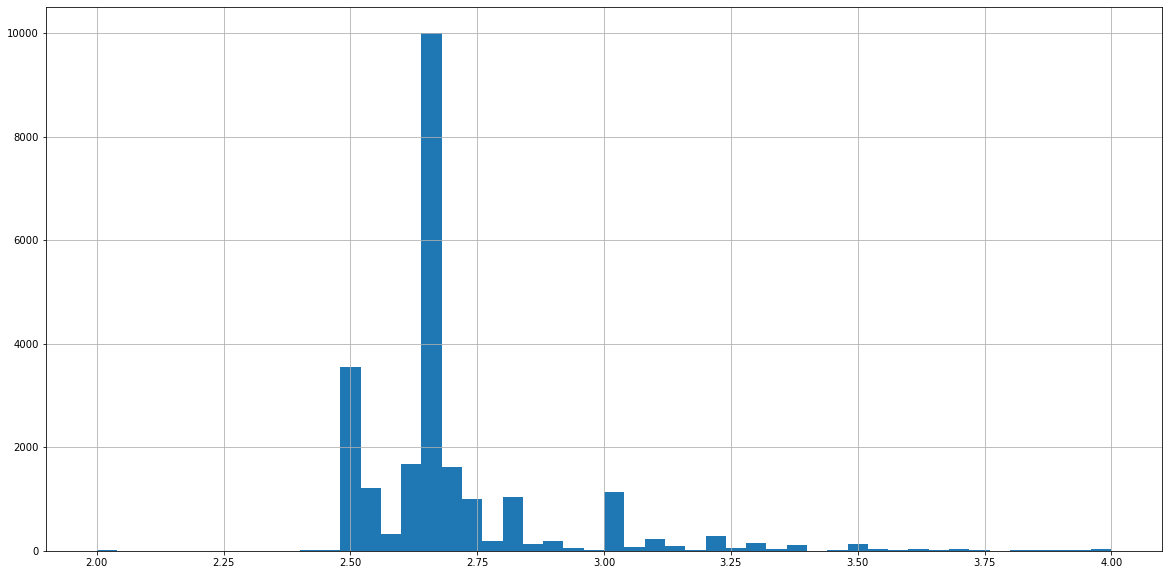

In [195]:
df['ceiling_height'].hist(bins=50, figsize=(20, 10), range=(2, 4))

Видим пик на 2,6 метра, что соответствует стандартам. Но также немало нестандартных квартир.

<a id='5.2'></a>

### 5.2 Изучим время продажи квартиры

count    23699.000000
mean       156.608844
std        213.546873
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64



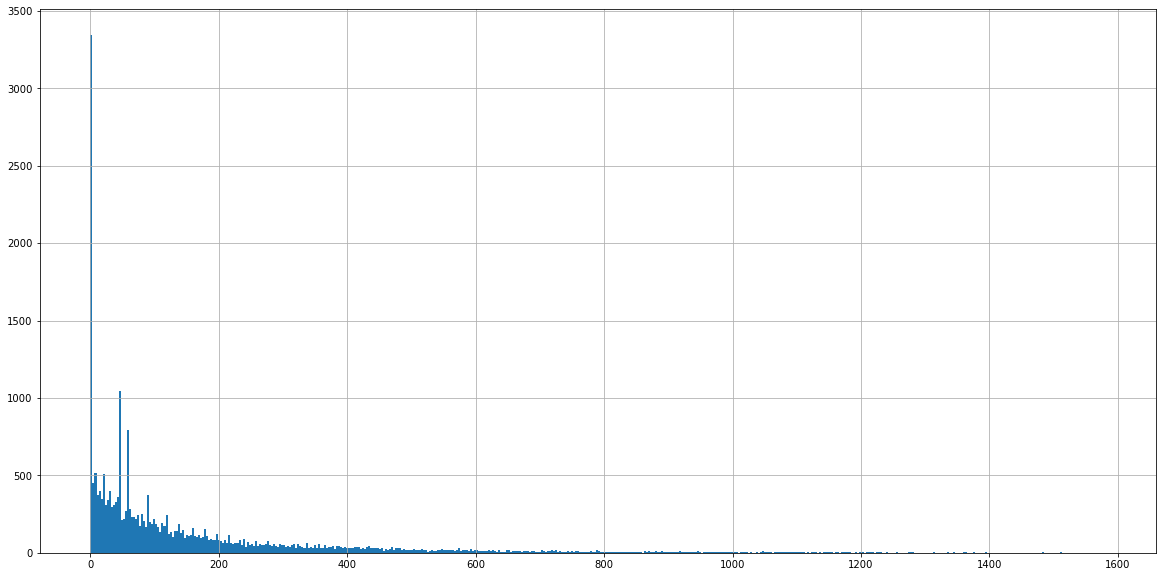

In [196]:
print(df['days_exposition'].describe())
print()
df['days_exposition'].hist(bins=500, figsize=(20, 10))

Есть очень большой пик на нулевом значении. Посчитаем межквартильный размах.

(-100.0, 600.0)

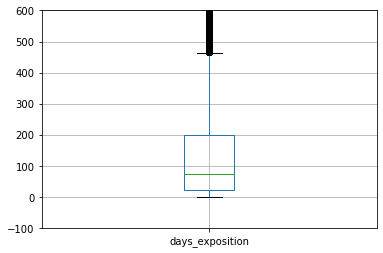

In [197]:
df.boxplot('days_exposition')
plt.ylim(-100, 600)

Из графика видим, что медиана тяготеет к низким значениям и составляет 74, т.е. в основном квартиры продаются за 2,5 месяца. Среднее значение в 2 раза выше медианы, что говорит о сильном влиянии выбросов.
Верхний ус межквартильного размаха ограничен значением примерно в 470 дней, следовательно квартиры за этой отметкой можно назвать продающимися необычайно долго. Стоит обратить внимание на такие квартиры, попытаться выяснить причину столь долгой продажи.
Нижний ус межквартильного размаха упирается в минимальное значение выборки - в ноль. Учитывая пик на гистограмме есть не менее 3000 квартир длительность продажи которых составила ноль дней, т.е. проданы в день публикации объявления. Можно сказать что эти квартиры были проданы необычайно быстро.

<a id='5.3'></a>

### 5.3 Убираем редкие и выбивающиеся значения

In [198]:
df = df.query('total_area <= 200 and last_price <= 30000000 and rooms <= 5 and 2 <= ceiling_height <= 4 and days_exposition <= 500')

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21474 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             21474 non-null  int64         
 1   last_price               21474 non-null  float64       
 2   total_area               21474 non-null  float64       
 3   first_day_exposition     21474 non-null  datetime64[ns]
 4   rooms                    21474 non-null  int64         
 5   ceiling_height           21474 non-null  float64       
 6   floors_total             21474 non-null  int32         
 7   living_area              21474 non-null  float64       
 8   floor                    21474 non-null  int64         
 9   is_apartment             21474 non-null  bool          
 10  studio                   21474 non-null  bool          
 11  open_plan                21474 non-null  bool          
 12  kitchen_area             21474 n

<a id='5.4'></a>

### 5.4 Изучим как факторы влияют на стоимость квартиры

In [200]:
# создадим отдельный датафрейм с интересующими нас колонками:
df_multi = df[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']]

# посчитаем корреляцию между всеми параметрами:
df_multi.corr().style.background_gradient('coolwarm')

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.000000,0.779225,0.474681,-0.335659
total_area,0.779225,1.000000,0.780875,-0.203956
rooms,0.474681,0.780875,1.000000,-0.139159
cityCenters_nearest,-0.335659,-0.203956,-0.139159,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002ADAE03F7F0>,
      dtype=object)

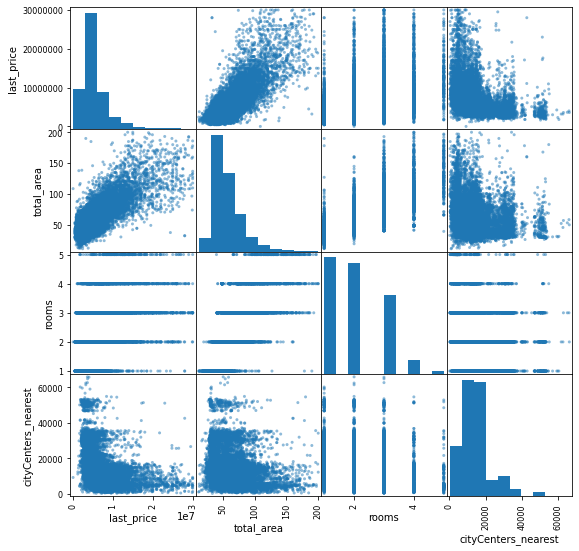

In [201]:
# выведем на экран график зависимостей:
pd.plotting.scatter_matrix(df_multi, figsize=(9, 9))

Каждая ячейка показывает взаимосвязь пары параметров. Изучим подробнее верхние 4 графика:<br><br>
1) Это гистограмма распределения по цене. Видно, что больше всего кваритр с ценой в районе 4 млн.<br>
2) Зависимость цены от площади. С самого начала графика видно, что величины увеличиваются вразнобой, однако общая тенденция хорошо видна - цена растет вместе с увеличением площади квартиры. Это подтверждается значением корреляции 0,78.<br>
3) Зависимость цены от количества комнат. Чем больше комнат тем больше цена. Но зависимость слебее чем от плащади квартиры, коэффициент корреляции 0,47. Видно, что для четерех и пятикомнатных квартир предложений на рынке меньше, чем двух-трехкомнатных.<br>
4) Зависимость цены от расстояния до центра города. Коэффициент корреляции -0,34, что соответсвует обратной зависимости, т.е. чем дальше от центра города тем дешевле жилье. Самая большая цена и больше всего предложений в промежутке от 0 до 20 км, далее идет резкий спад цены.

<b>Посмотрим как цена зависит от того, на каком этаже расположена квартира, дня недели, месяца и года размещения объявления.

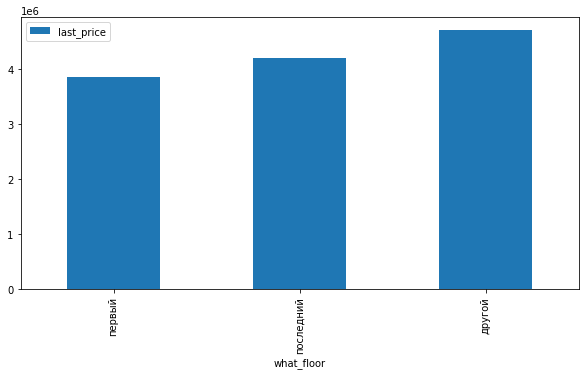

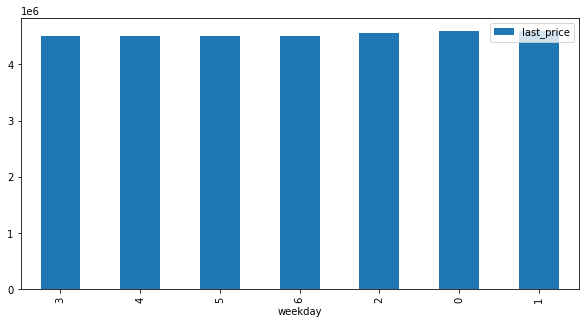

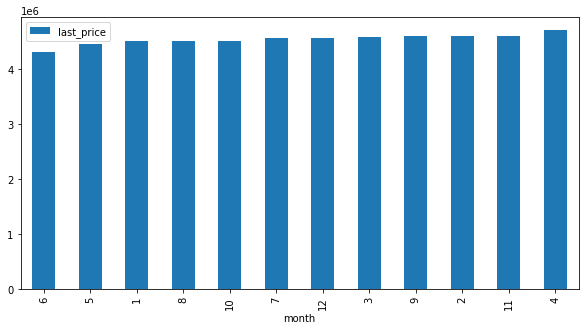

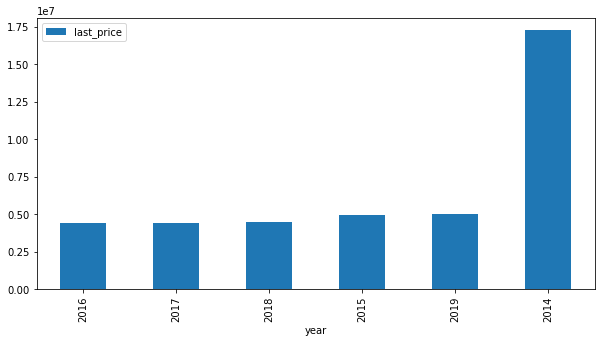

In [202]:
df_list_of_columns = ['what_floor', 'weekday', 'month', 'year']

for name in df_list_of_columns:
    (df
 .pivot_table(index=name, values='last_price', aggfunc='median')
 .sort_values(by='last_price')
 .plot(y='last_price', kind='bar', figsize=(10, 5))
)

1) Люди предпочитают квартиры между первым и последним, поэтому цена на них максимальна. Также предпочтение отдается последнему этажу чем первому.<br>
2-3) Какой-либо значимой зависимости цены от дня недели и месяца не налюдается.<br>
4) Зависимость от года размещения объявления показывает большой пик в 2-2,5 раза выше остальных лет в 2014 году. Возможно был какой-то кризис, из-за чего цены на недвижимость сильно выросли или был просто благоприятный год для работников этой отрасли.

<a id='5.5'></a>

### 5.5 Изучение ТОП-10

Выберем 10 населённых пунктов с наибольшим числом объявлений:

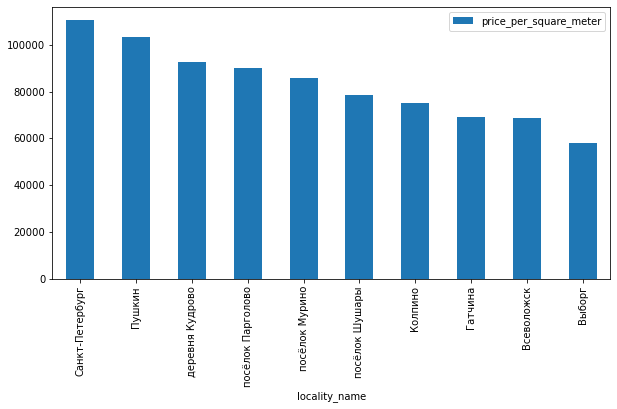

In [203]:
(df
 # считаем среднюю цену за квадратный метр среди топ-10 населенных пунктов
 .pivot_table(index='locality_name', aggfunc={'last_price':'count', 'price_per_square_meter':'mean'})
 .sort_values(by='last_price', ascending=False)
 .head(10)
 # отсортируем таблицу еще раз по средним значениям, чтобы выделить минимум и максимум
 .sort_values(by='price_per_square_meter', ascending=False)
 .plot(y='price_per_square_meter', kind='bar', figsize=(10, 5))
)

Самая высокая цена на квадратный метр вполне ожидаемо в Санкт-Петербурге, самая низкая - в Выборге.

<a id='5.6'></a>

### 5.6 Изучение центра города

Выделим квартиры в Санкт-Петербурге и выясним какая область входит в центр:  <b><em>Альтернативный вариант</b></em>

In [204]:
df_SPb = df[df['locality_name'] == 'Санкт-Петербург'].dropna(subset=['cityCenters_nearest'])
df_SPb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14008 entries, 0 to 23694
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             14008 non-null  int64         
 1   last_price               14008 non-null  float64       
 2   total_area               14008 non-null  float64       
 3   first_day_exposition     14008 non-null  datetime64[ns]
 4   rooms                    14008 non-null  int64         
 5   ceiling_height           14008 non-null  float64       
 6   floors_total             14008 non-null  int32         
 7   living_area              14008 non-null  float64       
 8   floor                    14008 non-null  int64         
 9   is_apartment             14008 non-null  bool          
 10  studio                   14008 non-null  bool          
 11  open_plan                14008 non-null  bool          
 12  kitchen_area             14008 n

In [205]:
df_SPb_center = df_SPb[['last_price', 'cityCenters_nearest']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002ADAFCEF850>,
      dtype=object)

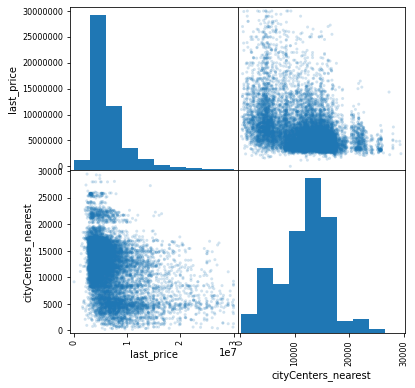

In [206]:
pd.plotting.scatter_matrix(df_SPb_center, figsize=(6, 6), alpha=0.2)

По графику можно заметить пик с большим количеством значений и максимальной ценой в районе 5 километров от центра. Будем считать, что область в радиусе пяти километров от центра, является центральной частью города.

<b>Анализ центральной части города</b><br>
Выделим область квартир в центре и проанализируем также как выше анализировали общий датафрейм:

In [207]:
df_SPb_center = df_SPb[df_SPb['cityCenters_nearest'] <= 4000]
df_SPb_center.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866 entries, 24 to 23602
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             866 non-null    int64         
 1   last_price               866 non-null    float64       
 2   total_area               866 non-null    float64       
 3   first_day_exposition     866 non-null    datetime64[ns]
 4   rooms                    866 non-null    int64         
 5   ceiling_height           866 non-null    float64       
 6   floors_total             866 non-null    int32         
 7   living_area              866 non-null    float64       
 8   floor                    866 non-null    int64         
 9   is_apartment             866 non-null    bool          
 10  studio                   866 non-null    bool          
 11  open_plan                866 non-null    bool          
 12  kitchen_area             866 non-

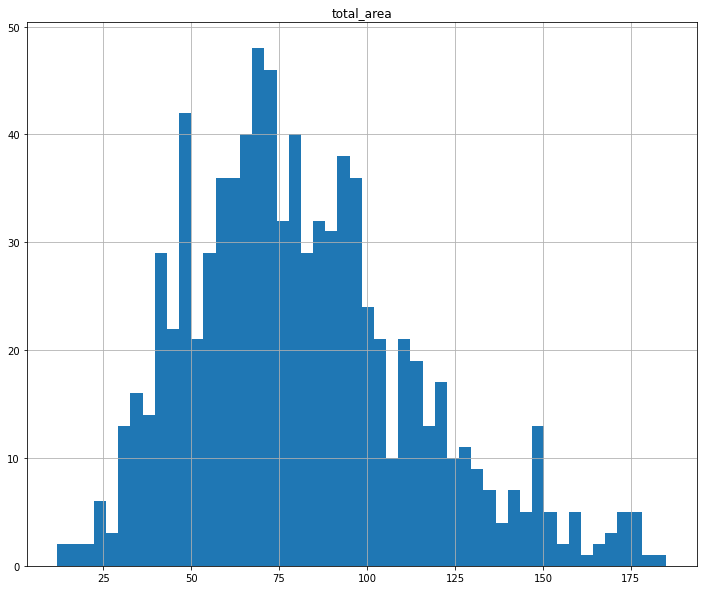

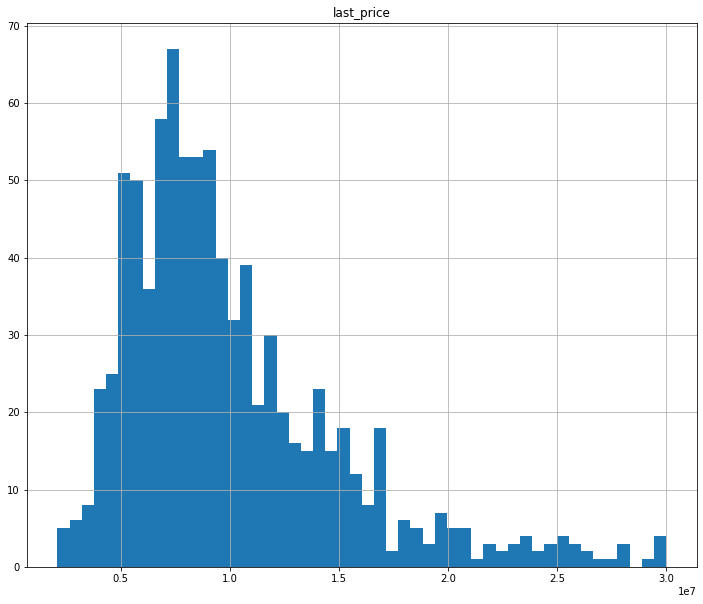

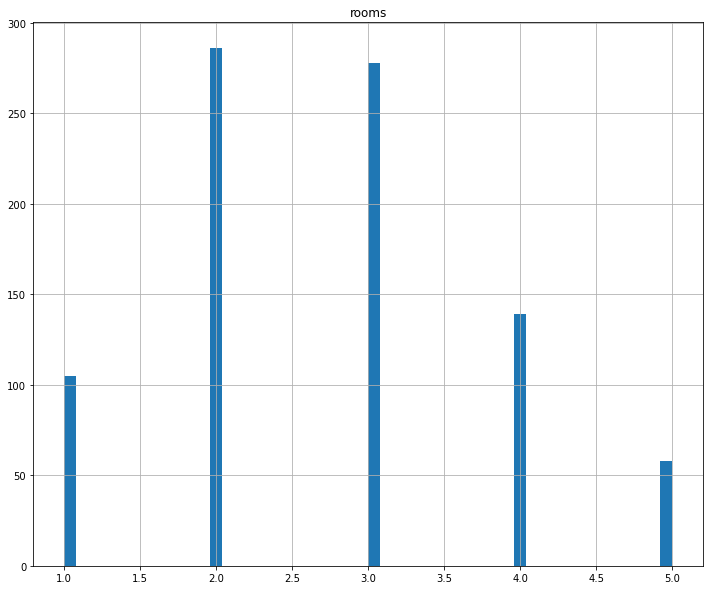

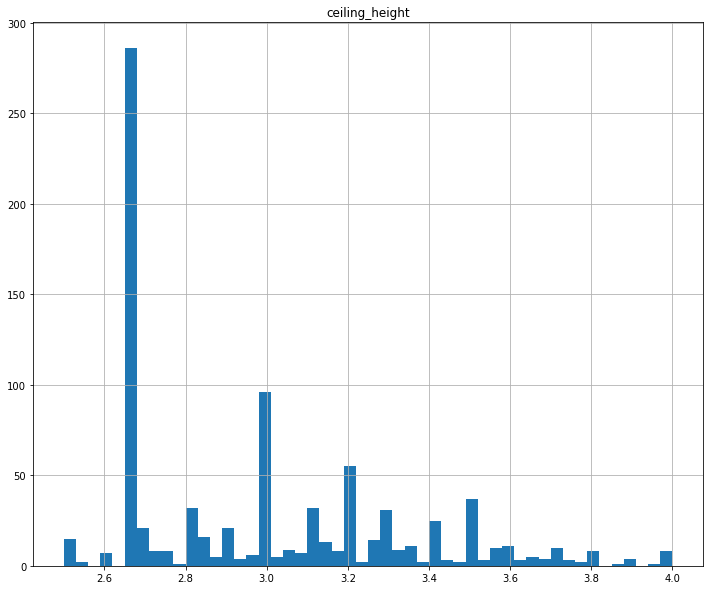

In [208]:
# строим гистаграммы для общей площади, цены, количества комнат и высоты потолков:

df_SPb_center_list_of_columns = ['total_area', 'last_price', 'rooms', 'ceiling_height']

for name in df_SPb_center_list_of_columns:
    df_SPb_center.hist(name, bins=50, figsize=(12, 10))

In [209]:
# создадим отдельный датафрейм с интересующими нас колонками:
df_SPb_center_multi = df_SPb_center[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']]

# посчитаем корреляцию между всеми параметрами:
df_SPb_center_multi.corr().style.background_gradient('coolwarm')

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.000000,0.665657,0.401677,-0.157348
total_area,0.665657,1.000000,0.773019,-0.078147
rooms,0.401677,0.773019,1.000000,-0.061385
cityCenters_nearest,-0.157348,-0.078147,-0.061385,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002ADB03AE0D0>,
      dtype=object)

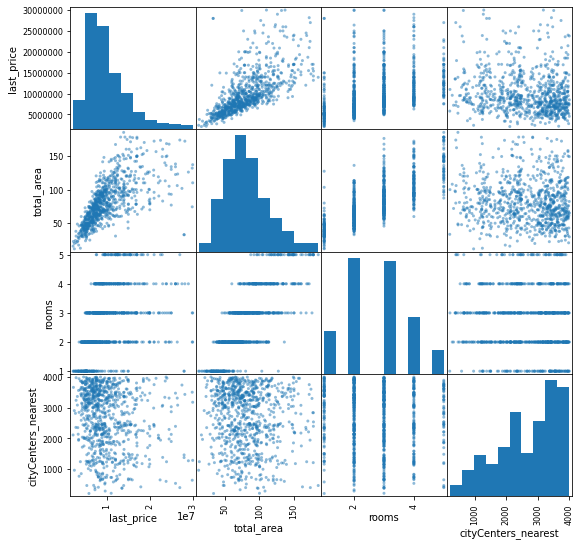

In [210]:
# выведем на экран график зависимостей:
pd.plotting.scatter_matrix(df_SPb_center_multi, figsize=(9, 9))

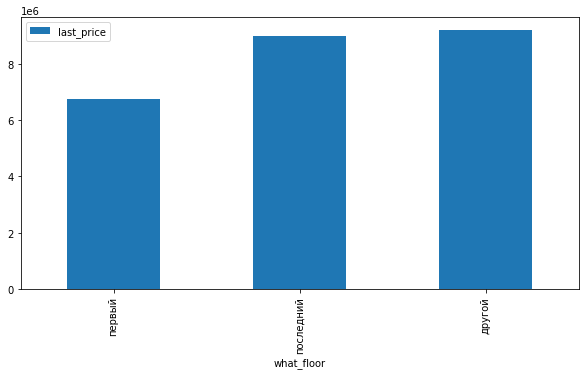

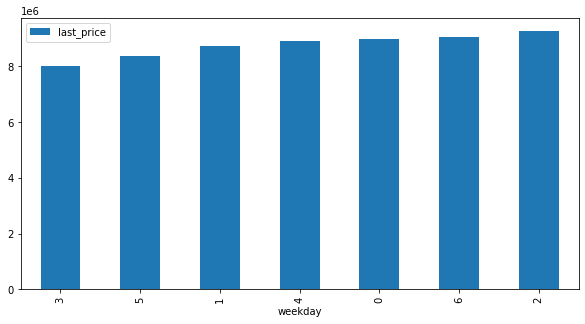

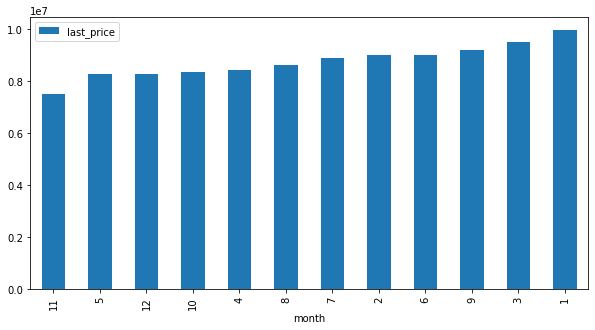

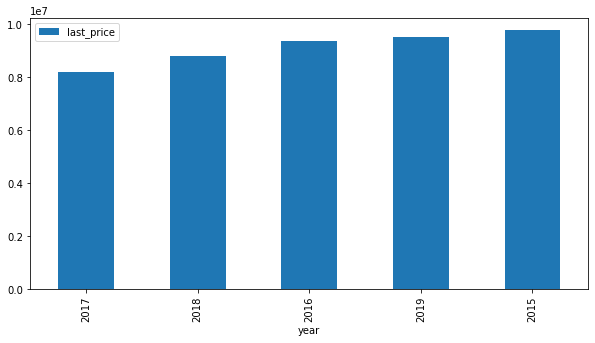

In [211]:
# строим графики зависимости цены от того, на каком этаже расположена квартира, дня недели, месяца и года размещения объявления:

df_SPb_center_list_of_columns2 = ['what_floor', 'weekday', 'month', 'year']

for name in df_SPb_center_list_of_columns2:
    (df_SPb_center
 .pivot_table(index=name, values='last_price', aggfunc='median')
 .sort_values(by='last_price')
 .plot(y='last_price', kind='bar', figsize=(10, 5))
)

<big><b>Выводы для центральной части города:</b></big><br>
    
1) Преобладают квартиры площадью от 60 до 100 квадратных метров.<br>
2) Основное распределение цен в промежутке от 5 до 14 млн. С пиком в районе 7 млн.<br>
3) Большинство квартир с количеством комнат 2 и 3, потом идут 4-х комнатные и однокомнатные.<br>
4) Основной пик по высоте потолков в районе 2,65 метра.<br><br><br>
    
<big><b>Зависимость цены от факторов:</b></big><br>
    
1) Максимум цены наблюдается в районе 7 млн.<br>
2) Зависимость цены от площади. До 50 кв. метров величины увеличиваются сгруппированно, дальше - вразброс, но общая тенденция видна, коэффициент корреляции 0,67.<br>
3) Зависимость цены от количесвта комнат. Хорошо видно увеличение стоимости при росте количества комнат от нуля до 3-х, далее предложений меньше и цена ниже. Из-за такого распределения коэффициент корреляции 0,4.<br>
4) Зависимость цены от удаленности от центра города. Коэффициент корреляции -0,16, т.е. практически нулевая зависимость между двумя величинами. Что логично, учитывая какую выборку мы взяли. Можно лишь сказать что количесвто предложений ближе к границе центра города увеличивается, что тоже логично потому, что в самом центре города обычно много правительственных зданий, парков, набережных, кремлей и прочего.<br>
5) Зависимость цены от этажа. Максимальная цена для квартир между первым и последним этажами. Квартиры на последнем этаже стоят дороже квартир на первом.<br>
6) Зависимость цены от дня недели. Цена максимальна если объявление опубликовали в понедельник, минмальна в конце рабочей недели и выходные - пятница, суббота и воскресенье.<br>
7) Зависимость цены от месяца. В августе и январе цены гораздо выше чем в остальные месяцы. Минимум в октябре.<br>
8) Зависимость цены от года. 2014 год не вошел в выборку, видимо весь бум продаж пришелся на окраины и прилегающие поселки. Из остальных 2015 и 2019 годы в лидерах стоимости жилья.<br><br><br>
    
<big><b>Основные отличия выводов по центральной части города от выводов по всей области:</b></big><br>
   
1) Квартиры в центре в основном больше. Пик сместился с 40 на 70 квадратных метров.<br>
2) Стоимость квартир в центре выше, изменение с 4 до 9 млн.<br>
3) Зависимость цены от площади. Коэффициент корреляции упал на 0,1. В целом зависимость сохранилась, но стала менее выраженной.<br>
4) Зависимость цены от количества комнат. Коэффициент корреляции упал на 0,07.<br>
5) Зависимость цены от удаленности от центра города. Различия сильные, но объясняются непосредственно географичиским фактором.<br>
6) Зависимость цены от даты публикации. В центральной части города появились пики стоимости для дня недели, месяца и года публикации. Пик продаж кваритр 2014-го года не коснулся центральной части города.

<a id='6'></a>

## 6. Вывод

Выявили зависимость цены на жилье от расчитанных параметров для всей области и отдельно для центра города. Установили основные отличия для этих двух территорий.